<a href="https://colab.research.google.com/github/dave502/NLP/blob/main/lesson_08/nlp_hw_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install stop_words pymorphy2

In [2]:
import pandas as pd
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Activation, Dropout, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Bidirectional, Masking, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from collections import defaultdict

In [4]:
pd.set_option('max_colwidth', 148)

####Загрузка данных

In [5]:
!wget -qO- https://www.dropbox.com/s/jha6yicxf80coll/data.tar.gz?dl=1 | tar -xvz

data/
data/test.csv
data/train.csv
data/val.csv


In [6]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/val.csv')
df_test = pd.read_csv('data/test.csv')

In [7]:
df_train.head()

,id,text,class
0,0,"@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.",0
1,1,"RT @GalyginVadim: Ребята и девчата!\nВсе в кино!!! ""Вот Это Любовь!""\nСегодня! Завтра! И потом!)))))\n#вотэтолюбовь",1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :),1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......)),1


In [8]:
morpher = MorphAnalyzer()
stopwords = set(get_stop_words("ru")) - {'не', 'нет', 'хорошо'}

def preprocess_text(text: pd.Series)->pd.Series:
  """
  функция обработки текста для pandas.Series
  """  
  # регулярное выражение для очистки текста
  url_pattern = "(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
  #punct_pattern = f"[{punct+'«—»'}]"
  smile_pattern = "(:D|D:)"
  usernames_pattern = "(@[\w]*|RT @[\w]*)"
  onlywords_pattern = "[^\w\b]|[^A-Za-zА-ЯЁа-яё]"
  pattern = f"{smile_pattern}|{url_pattern}|{usernames_pattern}|{onlywords_pattern}"

  # удаление лишних символов в соответствии с регулярными выражениями 
  new_text = text.replace(pattern, ' ', regex=True)
  
  # совмещение отрицаний 'не'/'нет' со следующим словом
  new_text = new_text.replace(r'((?<=[\s]не)|(?<=^Не))\s(?=[\w])', '')

  # лемматизация, удаление стоп-слов и запись результата в новую колонку
  new_text = new_text.apply(lambda x: [morpher.normal_forms(token)[0].strip().lower() for token in str(x).split()\
                                            if (token not in stopwords) and (len(token) > 2)])
  return new_text

Предварительная обработка текста и преобразование в массив

In [9]:
corpus_train = preprocess_text(df_train['text']).values
corpus_valid = preprocess_text(df_val['text']).values
corpus_test = preprocess_text(df_test['text']).values

In [11]:
corpus_train[:5]

array([list(['уезжаааааааать', 'хотеть', 'уезжать']),
       list(['ребята', 'девчата', 'всё', 'кино', 'вот', 'это', 'любовь', 'сегодня', 'завтра', 'вотэтолюбовь']),
       list(['кто', 'ненавидеть', 'пробка', 'ретвит']),
       list(['хотеться', 'котлета', 'киевск', 'запретный', 'плод']),
       list(['босапоп', 'есбосой', 'бояться', 'мороз'])], dtype=object)

Инициализация токенайзера

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus_train)

Токенизация документов

In [13]:
sequences_train = tokenizer.texts_to_sequences(corpus_train)
sequences_valid = tokenizer.texts_to_sequences(corpus_valid)
sequences_test = tokenizer.texts_to_sequences(corpus_test)

In [14]:
sequences_train[:5]

[[38077, 1, 553],
 [198, 6062, 37, 432, 38, 36, 153, 46, 7, 26405],
 [100, 161, 626, 548],
 [47, 4733, 26406, 20854, 10265],
 [38078, 38079, 144, 346]]

In [16]:
# размер словаря
word_count = len(tokenizer.index_word) + 1
# максимальное число токенов в документах
training_len = max([len(text) for text in corpus_train])

Выравнивание длины документов

In [17]:
X_train = pad_sequences(sequences_train, training_len)
X_valid = pad_sequences(sequences_valid, training_len)

In [18]:
X_train[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 38077,     1,   553],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   198,  6062,    37,
          432,    38,    36,   153,    46,     7, 26405],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   100,   161,   626,   548],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    47,  4733, 26406, 20854, 10265],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 38078, 38079,   144,   346]],

Создание выборок классов

In [13]:
y_train = df_train['class'].values
y_valid = df_val['class'].values

Инициализация параметров обучения

In [29]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3) 
BATCH_SIZE = 64
EPOCHS = 10
results = defaultdict(list)

####Обучение сеток

---
**RNN**

EMBEDDING -> RNN(64) -> DENSE(64, relu) -> DROPOUT(.2) -> DENSE(1, σ)

---

In [27]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=word_count, input_length=training_len, output_dim=30, mask_zero=True))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
%%time
history_rnn = model_rnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 126s 49ms/step - loss: 0.5698 - accuracy: 0.6995 - val_loss: 0.5383 - val_accuracy: 0.7246
Epoch 2/10
2552/2552 [==============================] - 122s 48ms/step - loss: 0.4335 - accuracy: 0.7967 - val_loss: 0.5632 - val_accuracy: 0.7243
Epoch 3/10
2552/2552 [==============================] - 113s 44ms/step - loss: 0.2965 - accuracy: 0.8663 - val_loss: 0.6526 - val_accuracy: 0.7045
Epoch 4/10
2552/2552 [==============================] - 105s 41ms/step - loss: 0.2156 - accuracy: 0.9042 - val_loss: 0.7678 - val_accuracy: 0.7004
CPU times: user 10min 51s, sys: 1min 19s, total: 12min 10s
Wall time: 7min 45s


In [30]:
score = model_rnn.evaluate(X_valid, y_valid, batch_size=512, verbose=1)
results['model'].append('RNN')
results['score'].append(score[0])
results['accuracy'].append(score[1])

45/45 [==============================] - 0s 6ms/step - loss: 0.7794 - accuracy: 0.6967


---
**LSTM**

EMBEDDING -> LSTM(64) -> DENSE(64, relu) -> DROPOUT(.2) -> DENSE(1, σ)

---

In [32]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=word_count, input_length=training_len, output_dim=30, mask_zero=True))
model_lstm.add(LSTM(64, recurrent_dropout=0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
%%time
history_lstm = model_lstm.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 310s 122ms/step - loss: 0.5643 - accuracy: 0.7065 - val_loss: 0.5391 - val_accuracy: 0.7245
Epoch 2/10
2552/2552 [==============================] - 318s 125ms/step - loss: 0.4536 - accuracy: 0.7871 - val_loss: 0.5496 - val_accuracy: 0.7230
Epoch 3/10
2552/2552 [==============================] - 340s 133ms/step - loss: 0.3674 - accuracy: 0.8315 - val_loss: 0.5877 - val_accuracy: 0.7185
Epoch 4/10
2552/2552 [==============================] - 294s 115ms/step - loss: 0.3077 - accuracy: 0.8589 - val_loss: 0.6694 - val_accuracy: 0.7118
CPU times: user 29min 22s, sys: 3min 11s, total: 32min 33s
Wall time: 21min 3s


In [36]:
score = model_lstm.evaluate(X_valid, y_valid, batch_size=512, verbose=1)
results['model'].append('LSTM')
results['score'].append(score[0])
results['accuracy'].append(score[1])

45/45 [==============================] - 1s 14ms/step - loss: 0.6735 - accuracy: 0.7124


---
**GRU**

EMBEDDING -> GRU(64) -> DENSE(64, relu) -> DROPOUT(.2) -> DENSE(1, σ)

---

In [40]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=word_count, input_length=training_len, output_dim=30, mask_zero=True))
model_gru.add(GRU(64, recurrent_dropout=0.2))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
%%time
history_gru = model_gru.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 261s 101ms/step - loss: 0.5664 - accuracy: 0.7019 - val_loss: 0.5391 - val_accuracy: 0.7231
Epoch 2/10
2552/2552 [==============================] - 252s 99ms/step - loss: 0.4540 - accuracy: 0.7843 - val_loss: 0.5524 - val_accuracy: 0.7245
Epoch 3/10
2552/2552 [==============================] - 249s 98ms/step - loss: 0.3663 - accuracy: 0.8306 - val_loss: 0.6052 - val_accuracy: 0.7172
Epoch 4/10
2552/2552 [==============================] - 254s 100ms/step - loss: 0.3047 - accuracy: 0.8597 - val_loss: 0.6799 - val_accuracy: 0.7158
CPU times: user 24min 57s, sys: 2min 42s, total: 27min 40s
Wall time: 16min 56s


In [42]:
score = model_gru.evaluate(X_valid, y_valid, batch_size=512, verbose=1)
results['model'].append('GRU')
results['score'].append(score[0])
results['accuracy'].append(score[1])

45/45 [==============================] - 1s 14ms/step - loss: 0.6959 - accuracy: 0.7142


---
**CNN**

EMBEDDING -> CONV1D(64) -> RELU -> MAXPOOL -> DENSE(64, relu) -> DROPOUT(.2) -> DENSE(1, σ)

---

In [44]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=word_count, input_length=training_len, output_dim=30, mask_zero=True))
model_cnn.add(Conv1D(64, 3))
model_cnn.add(Activation('relu'))
model_cnn.add(GlobalMaxPool1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
%%time
history_cnn = model_cnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 21s 6ms/step - loss: 0.5698 - accuracy: 0.6974 - val_loss: 0.5373 - val_accuracy: 0.7255
Epoch 2/10
2552/2552 [==============================] - 14s 6ms/step - loss: 0.4310 - accuracy: 0.8022 - val_loss: 0.5538 - val_accuracy: 0.7209
Epoch 3/10
2552/2552 [==============================] - 14s 5ms/step - loss: 0.2781 - accuracy: 0.8824 - val_loss: 0.6724 - val_accuracy: 0.7089
Epoch 4/10
2552/2552 [==============================] - 14s 5ms/step - loss: 0.1795 - accuracy: 0.9255 - val_loss: 0.8693 - val_accuracy: 0.7058
CPU times: user 1min 9s, sys: 6.54 s, total: 1min 16s
Wall time: 1min 3s


In [46]:
score = model_cnn.evaluate(X_valid, y_valid, batch_size=512, verbose=1)
results['model'].append('CNN')
results['score'].append(score[0])
results['accuracy'].append(score[1])

45/45 [==============================] - 0s 3ms/step - loss: 0.8973 - accuracy: 0.7004


---
**CNN RNN**

EMBEDDING -> CONV1D(64) -> RELU -> MAXPOOL -> RNN(64) -> DENSE(64, relu) -> DROPOUT(.2) -> DENSE(1, σ)

---

In [51]:
model_cnn_rnn = Sequential()
model_cnn_rnn.add(Embedding(input_dim=word_count, input_length=training_len, output_dim=30, mask_zero=True))
model_cnn_rnn.add(Conv1D(64, 3))
model_cnn_rnn.add(Activation('relu'))
model_cnn_rnn.add(MaxPooling1D(pool_size=2))
model_cnn_rnn.add(SimpleRNN(64))
model_cnn_rnn.add(Dense(64, activation='relu'))
model_cnn_rnn.add(Dropout(0.2))
model_cnn_rnn.add(Dense(1, activation='sigmoid'))
model_cnn_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
%%time
history_cnn_rnn = model_cnn_rnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 41s 16ms/step - loss: 0.6002 - accuracy: 0.6680 - val_loss: 0.5716 - val_accuracy: 0.6960
Epoch 2/10
2552/2552 [==============================] - 40s 16ms/step - loss: 0.4691 - accuracy: 0.7748 - val_loss: 0.5885 - val_accuracy: 0.6960
Epoch 3/10
2552/2552 [==============================] - 41s 16ms/step - loss: 0.3219 - accuracy: 0.8521 - val_loss: 0.6730 - val_accuracy: 0.6847
Epoch 4/10
2552/2552 [==============================] - 41s 16ms/step - loss: 0.2296 - accuracy: 0.8952 - val_loss: 0.8668 - val_accuracy: 0.6802
CPU times: user 3min 41s, sys: 24.1 s, total: 4min 5s
Wall time: 2min 42s


In [54]:
score = model_cnn_rnn.evaluate(X_valid, y_valid, batch_size=512, verbose=1)
results['model'].append('CNN_RNN')
results['score'].append(score[0])
results['accuracy'].append(score[1])

45/45 [==============================] - 0s 4ms/step - loss: 0.9029 - accuracy: 0.6683


---
**RNN CNN**

EMBEDDING ->  RNN(64, +sequences) -> CONV1D(64) -> RELU -> MAXPOOL ->DENSE(64, relu) -> DROPOUT(.2) -> DENSE(1, σ)

---

In [57]:
model_rnn_cnn = Sequential()
model_rnn_cnn.add(Embedding(input_dim=word_count, input_length=training_len, output_dim=30, mask_zero=True))
model_rnn_cnn.add(SimpleRNN(64, return_sequences=True))
model_rnn_cnn.add(Conv1D(64, 3))
model_rnn_cnn.add(Activation('relu'))
model_rnn_cnn.add(GlobalMaxPool1D())
model_rnn_cnn.add(Dense(64, activation='relu'))
model_rnn_cnn.add(Dropout(0.2))
model_rnn_cnn.add(Dense(1, activation='sigmoid'))
model_rnn_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
%%time
history_rnn_cnn = model_rnn_cnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 115s 44ms/step - loss: 0.5715 - accuracy: 0.6982 - val_loss: 0.5373 - val_accuracy: 0.7254
Epoch 2/10
2552/2552 [==============================] - 117s 46ms/step - loss: 0.4455 - accuracy: 0.7917 - val_loss: 0.5493 - val_accuracy: 0.7229
Epoch 3/10
2552/2552 [==============================] - 114s 45ms/step - loss: 0.3172 - accuracy: 0.8600 - val_loss: 0.6514 - val_accuracy: 0.7146
Epoch 4/10
2552/2552 [==============================] - 112s 44ms/step - loss: 0.2260 - accuracy: 0.9010 - val_loss: 0.7747 - val_accuracy: 0.7087
CPU times: user 11min 4s, sys: 1min 24s, total: 12min 28s
Wall time: 7min 37s


In [63]:
score = model_rnn_cnn.evaluate(X_valid, y_valid, batch_size=512, verbose=1)
results['model'].append('RNN_CNN')
results['score'].append(score[0])
results['accuracy'].append(score[1])

45/45 [==============================] - 0s 7ms/step - loss: 0.8019 - accuracy: 0.7042


In [64]:
results['time'] = ['7min 45s', '21min 3s', '16min 56s', '1min 3s', '2min 42s', '7min 37s']

---
**BIDIRRECTIONAL RNN**

EMBEDDING ->  BIDIRRECTIONAL RNN(64) -> DENSE(64, relu) -> DROPOUT(.2) -> DENSE(1, σ)

---

In [69]:
model_rnn2 = Sequential()
model_rnn2.add(Embedding(input_dim=word_count, input_length=training_len, output_dim=30, mask_zero=True))
model_rnn2.add(Bidirectional(SimpleRNN(64)))
model_rnn2.add(Dense(64, activation='relu'))
model_rnn2.add(Dropout(0.2))
model_rnn2.add(Dense(1, activation='sigmoid'))
model_rnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
%%time
history_rnn2 = model_rnn2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 220s 86ms/step - loss: 0.5672 - accuracy: 0.7018 - val_loss: 0.5384 - val_accuracy: 0.7227
Epoch 2/10
2552/2552 [==============================] - 205s 80ms/step - loss: 0.4227 - accuracy: 0.8055 - val_loss: 0.5653 - val_accuracy: 0.7227
Epoch 3/10
2552/2552 [==============================] - 200s 78ms/step - loss: 0.2669 - accuracy: 0.8850 - val_loss: 0.6903 - val_accuracy: 0.7056
Epoch 4/10
2552/2552 [==============================] - 200s 79ms/step - loss: 0.1793 - accuracy: 0.9230 - val_loss: 0.8712 - val_accuracy: 0.6933
CPU times: user 20min 15s, sys: 2min 34s, total: 22min 50s
Wall time: 13min 46s


In [85]:
score = model_rnn2.evaluate(X_valid, y_valid, batch_size=512, verbose=1)
results['model'].append('BidirRNN')
results['score'].append(score[0])
results['accuracy'].append(score[1])
results['time'].append('13min 46s')

45/45 [==============================] - 0s 10ms/step - loss: 0.8764 - accuracy: 0.6859


####Вывод результатов

In [94]:
df_results = pd.DataFrame(results)
df_results.set_index('model', inplace=True)
df_results

,score,accuracy,time
model,,,
RNN,0.779363,0.696733,7min 45s
LSTM,0.673540,0.712384,21min 3s
GRU,0.695941,0.714235,16min 56s
CNN,0.897344,0.700392,1min 3s
CNN_RNN,0.902855,0.668298,2min 42s
RNN_CNN,0.801917,0.704184,7min 37s
BidirRNN,0.876449,0.685888,13min 46s


Результаты по метрике accuracy и времени

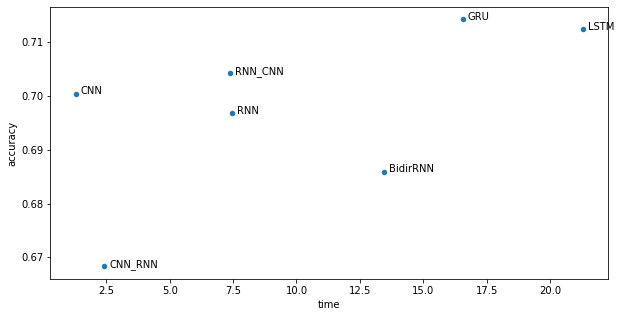

In [63]:
df_results['time'] = df_results['time'].str.replace('min ','.').str.replace('s', '').astype(float)
ax = df_results.plot.scatter('time', 'accuracy', figsize=(10,5))
for idx, row in df_results.iterrows():
    ax.annotate(idx, (row['time']+0.2, row['accuracy']))

Лучшие результаты по метрике accurcy показала модель с GRU слоем, в результате превзойдя LSTM по метрике и по времени, хоть и незначительно. <br> Простая RNN немного уступает по качеству LSTM и GRU, но сильно выигрывает по времени. Так как в твитах короткие документы, то сильного отставания у RNN нет. <br>Свёрточная модель CNN показала лучшие результаты по времени среди всех моделей и по качеству находится на уровне рекуррентных сеток. <br>Двунаправленная RNN показала плохие результаты, вероятно из-за коротках документов преимущества у неё нет. <br>Комбинация CNN-RNN показала худшие результаты, опять же, скорее всего из-за коротких документов в RNN попадает недостаточно информации. <br>А вот RNN-CNN показала неплохие рузультаты, в CNN попадали из RNN контекстно-зависимые токены, что позволило немного улучшить метрику по сравнению с обычной CNN.
Вывод для данного корпуса: если нужна максимальная скорость обработки, лучше воспользоваться CNN, если важно качество работы сетки - тогда GRU/

PS. Ещё один шанс для CNN-RNN. Уберём пулинг и проверим результат

In [79]:
model_cnn_rnn = Sequential()
model_cnn_rnn.add(Embedding(input_dim=word_count, input_length=training_len, output_dim=30, mask_zero=True))
model_cnn_rnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn_rnn.add(SimpleRNN(64))
model_cnn_rnn.add(Dense(64, activation='relu'))
model_cnn_rnn.add(Dropout(0.2))
model_cnn_rnn.add(Dense(1, activation='sigmoid'))
model_cnn_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [80]:
%%time
history_cnn_rnn = model_cnn_rnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 76s 30ms/step - loss: 0.5735 - accuracy: 0.6920 - val_loss: 0.5392 - val_accuracy: 0.7263
Epoch 2/10
2552/2552 [==============================] - 73s 29ms/step - loss: 0.4322 - accuracy: 0.7997 - val_loss: 0.5548 - val_accuracy: 0.7146
Epoch 3/10
2552/2552 [==============================] - 72s 28ms/step - loss: 0.2873 - accuracy: 0.8752 - val_loss: 0.6673 - val_accuracy: 0.7047
Epoch 4/10
2552/2552 [==============================] - 70s 27ms/step - loss: 0.1919 - accuracy: 0.9184 - val_loss: 0.7806 - val_accuracy: 0.6963
CPU times: user 6min 51s, sys: 49.9 s, total: 7min 41s
Wall time: 4min 51s


In [82]:
score = model_cnn_rnn.evaluate(X_valid, y_valid, batch_size=512, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 6ms/step - loss: 0.7891 - accuracy: 0.6897
Test score: 0.7890775799751282
Test accuracy: 0.6897236108779907


Результаты сетки без пулинга стали лучше, но всё равно не лучше простой CNN